# FORECAST MODELS

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline

import seaborn as sns
import statsmodels.api as sm

import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

import requests
import json
from bs4 import BeautifulSoup
from pandas import DataFrame as df

# Forecasting Intro:

- You are going to choose different models depending upon the data you have. We will train our model on the first group of data (Training Data : 1st 80%). Then we test the model using the last part of our data (Test Date : Last 20%). All along we are modeling using real known true results. We should forecast into the future the same length of time we test for.

# Get our Data:

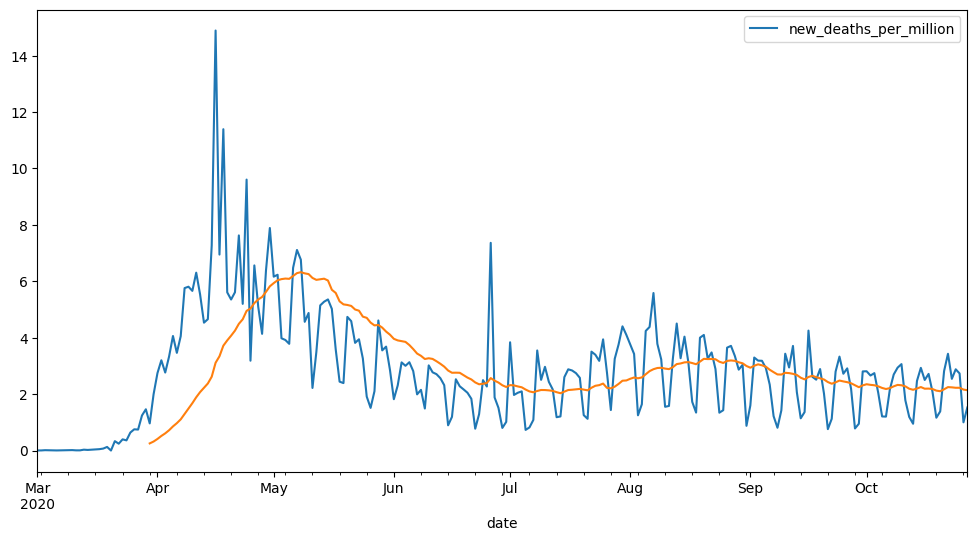

In [117]:
# Import Our World in Data CSV
# https://github.com/owid/covid-19-data/tree/master/public/data
owid_df = pd.read_csv('owid-covid-data.csv')

owid_df.columns # Show all columns

# Create Numpy array of unique countries
covid_df = owid_df.location.unique()

# Get indexes for United States
indexer = owid_df[owid_df['location']=='United States'].index

# Get dataframe location and column data for country name
covid_df = owid_df.loc[indexer, 'date':'new_deaths_per_million']

# Delete NaN values
covid_df = covid_df.dropna()

# Convert date to datetime
covid_df['date'] = pd.to_datetime(covid_df['date'])
# Set date as index
covid_df.set_index('date', inplace=True)

# Remove all columns except for what I want
covid_df.drop(columns=covid_df.columns.difference(['new_deaths_per_million']), inplace=True)

# Plot a 30 day moving average
covid_df.plot(figsize=(12,6))
covid_df.rolling(window=30).mean()['new_deaths_per_million'].plot()


covid_df = covid_df.asfreq('d')
train_df = covid_df.iloc[:192]
test_df = covid_df.iloc[191:]


# Holt-Winters Model with training data:

<Axes: xlabel='date'>

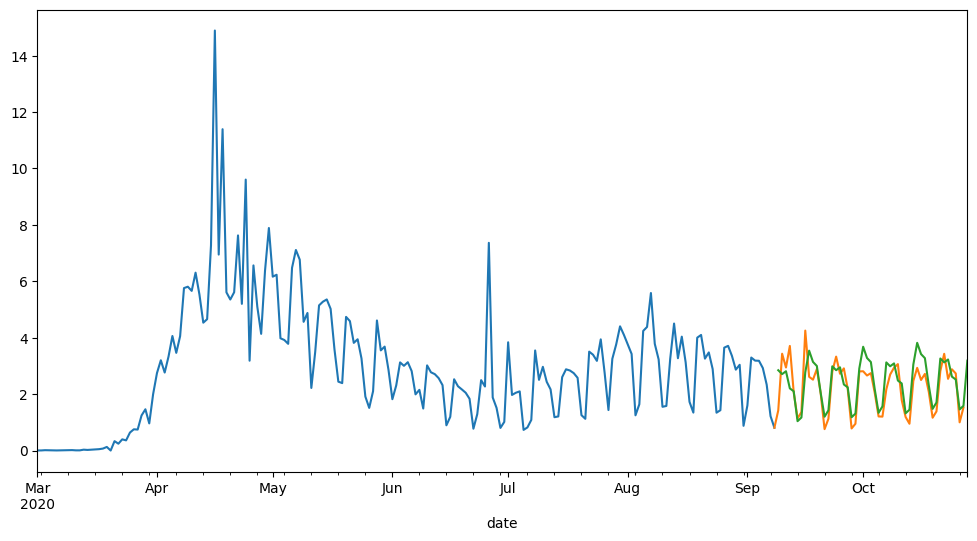

In [118]:
# The Holt - Winters Method actually models 3 aspects of the 
# time series being the average, trend and seasonality. 
# In doing so it tries to predict the future provided the 
# series is seasonal and repetitive over time.

from statsmodels.tsa.holtwinters import ExponentialSmoothing

# There is no exponential growth so I'll use additive
# I picked 14 for period because it provided the best result
fit_model = ExponentialSmoothing(train_df['new_deaths_per_million'],
                                 trend='add', seasonal='add',
                                 seasonal_periods=14).fit()
# # We can now make predictions 60 days into the future
prediction = fit_model.forecast(50)
prediction

# Plot training, testing and projection data
train_df['new_deaths_per_million'].plot(figsize=(12,6))
test_df['new_deaths_per_million'].plot()
# prediction.plot(xlim=['2020-09-09','2020-10-28'])
prediction.plot()


# Evaluating Predictions :
                            
- I'll look at different options for evaluating my forecasts being Mean Absolute, Mean Squared and Root Mean Square Error.

# Mean Absolute Error ->


- Mean Absolute Error : Take the difference between our prediction and the true result and find the average. The negative is that a few major errors my skew the results.
                        
                    \frac{1}{n}\sum_{n}^{i=1}|y_i - \hat{y}_i|


In [120]:
def mae(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return np.mean(np.abs(y1_np - y2_np), axis=axis)

mae(test_df, prediction)

#########

from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_absolute_error(test_df, prediction)

0.8144482619952786

# Mean Squared Error ->

- Mean Squared Error : Takes the difference like before and finds the mean, but since we square the results large errors are squared which dramatically shows those errors in the model. The negative is that the units are squared distorting the results.

In [121]:
def mse(y1, y2, axis=0):
    y1_np = y1.to_numpy()
    y2_np = y2.to_numpy()
    return ((y1_np - y2_np) ** 2).mean(axis=axis)
# axis=0 is per-column, ax=1 is per-row and ax=None is total 
mse(test_df, prediction)

#########

mean_squared_error(test_df, prediction)

0.97237662966087

# Root Mean Squared Error->

- Root Mean Squared Error : By finding the square root we return to the original unit used. When evaluating how bad an error is it depends on how large your values are. If we found our model was off by 100,000 nationally that wouldn't be as big a deal as if we were off by 100,000 in a small city.

In [122]:
np.sqrt(mean_squared_error(test_df, prediction))

0.9860915929369188

# Predicting the Future :

<Axes: xlabel='date'>

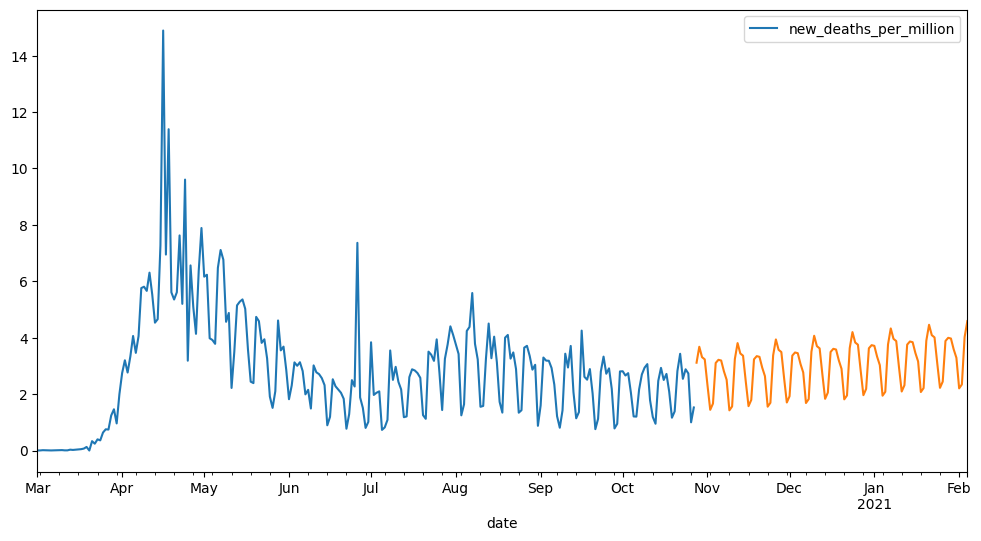

In [124]:
covid_model = ExponentialSmoothing(covid_df['new_deaths_per_million'],
                                  trend='add',
                                  seasonal='add',
                                  seasonal_periods=14).fit()

# Let's predict 100 days into the future
covid_forecast = covid_model.forecast(100)

# Convert numpy array to pandas dataframe
covid_df = pd.DataFrame(covid_df)

# Print original and then our prediction
covid_df.plot(figsize=(12,6))
covid_forecast.plot()